<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/LSTM_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroup_Test_A%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using LSTM Model based on Patient Visits Medical Laboratory Data (GroupTestA)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 9.5MB 17.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=a0cc35c868607cafd63ba1b0504f4a20cc6e6b425dbce5120583740c09852159
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 64kB/s 
     |████████████████████████████████| 901kB 32.4MB/s 
     |████████████████████████████████| 10.1MB 34.7MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 5.1MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import time
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
from datetime import datetime
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import glob
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model, save_model
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [5]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data['weekday']= data.apply(lambda row: row['date'].weekday(),axis=1)
data['weekday'] = (data["weekday"] < 5).astype(int)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1348 non-null   datetime64[ns]
 1   hm        1348 non-null   int64         
 2   hm_aw     1348 non-null   int64         
 3   hm_am     1348 non-null   int64         
 4   cc        1348 non-null   int64         
 5   cc_aw     1348 non-null   int64         
 6   cc_am     1348 non-null   int64         
 7   day_week  1348 non-null   int64         
 8   weekday   1348 non-null   int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 94.9 KB


In [7]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1


## **Step#2 Data Processing**

In [8]:
df = data.loc[:,['date', 'hm', 'hm_aw', 'hm_am', 'weekday']]
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df = df.set_index('date')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1348 entries, 2017-07-01 to 2021-03-09
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   hm       1348 non-null   int64
 1   hm_aw    1348 non-null   int64
 2   hm_am    1348 non-null   int64
 3   weekday  1348 non-null   int64
dtypes: int64(4)
memory usage: 52.7 KB


### **Stationary Test**

In [10]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [11]:
#Loop to check all columns of the DF
import functools
df.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                  -2.5335
p-value                          0.1075
#Lags Used                      20.0000
Number of Observations Used   1327.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.7086
p-value                          0.0726
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.8019
p-value                          0.0580
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:

hm         None
hm_aw      None
hm_am      None
weekday    None
dtype: object

### **Differencing**

In [12]:
df_diff = df.diff().dropna()
df_diff = df_diff.astype(int)
df_diff.head()

,hm,hm_aw,hm_am,weekday
date,,,,
2017-07-02,-13,5,-1,0
2017-07-03,21,1,-3,1
2017-07-04,13,2,-2,0
2017-07-05,8,6,1,0
2017-07-06,-1,6,0,0


### **Reshaping**

In [13]:
dataset = df_diff.values #numpy.ndarray
dataset = dataset.astype('int')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### **Splitting Data**

In [14]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4310 1078


### **Time Frames Lookbacks**

In [15]:
''' Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [16]:
''' Creating time frames with look backs '''
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

4309
1077


In [17]:
a = testX
a.shape

(1077, 1)

In [18]:
''' Re-shaping data for model requirement '''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('Training data size:',trainX.shape)
print('Test data size:',testX.shape)

Training data size: (4309, 1, 1)
Test data size: (1077, 1, 1)


## **Step#3 Fitting and Training Model**

In [19]:
''' Fitting the data in LSTM Deep Learning model '''

model = tf.keras.Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.5)) 
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

start = timer()
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=True)
end = timer()

# Training Phase
model.summary()

Epoch 1/50
44/44 [==============================] - 3s 17ms/step - loss: 0.2215 - val_loss: 0.0699
Epoch 2/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0497 - val_loss: 0.0299
Epoch 3/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0437 - val_loss: 0.0255
Epoch 4/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0435 - val_loss: 0.0245
Epoch 5/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0256
Epoch 6/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0400 - val_loss: 0.0242
Epoch 7/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0388 - val_loss: 0.0236
Epoch 8/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0378 - val_loss: 0.0230
Epoch 9/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0229
Epoch 10/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.0219
Epoch 11/50
44/44 

In [20]:
print("Time Consumption", end-start)

Time Consumption 17.812555092999986


## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

In [21]:
''' Predicting 1 years data based on 5 years of previous data '''
yhat = model.predict(testX)

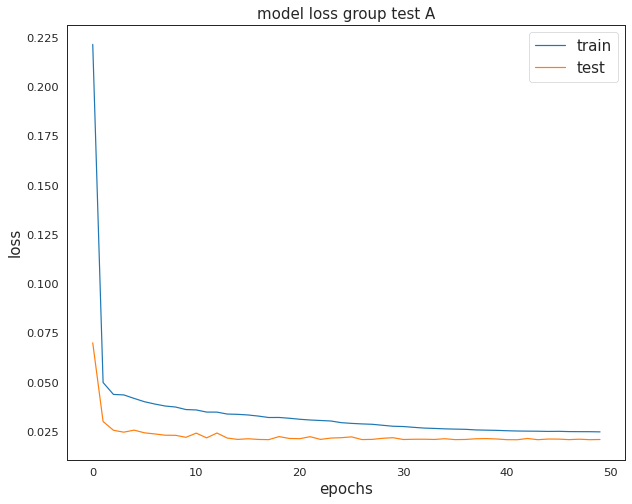

In [22]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.title('model loss group test A',size=15)
plt.ylabel('loss',size=15)
plt.xlabel('epochs',size=15)
plt.legend(loc='upper right',fontsize=15)

plt.show()

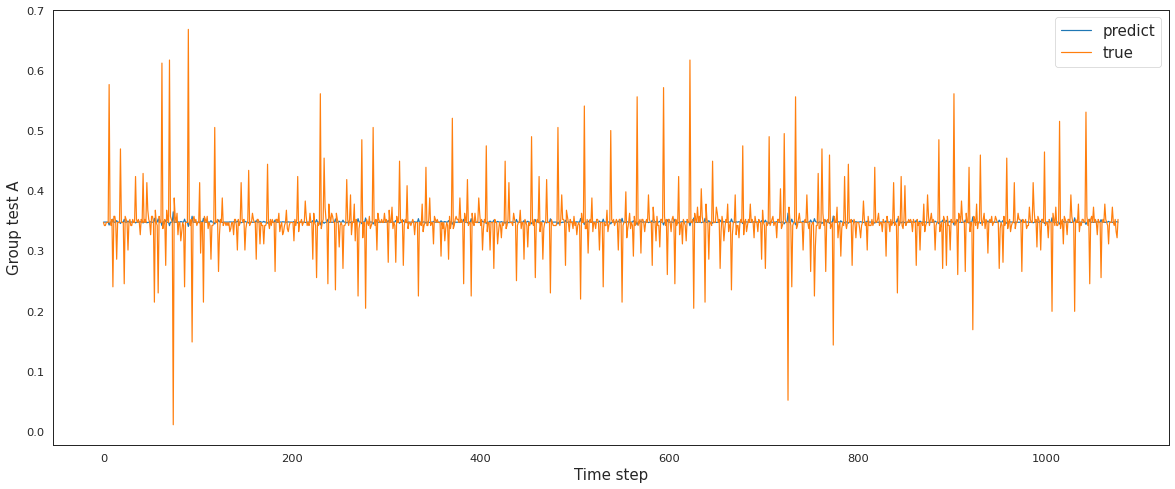

In [23]:
''' Plotting the first 500 entries to see prediction '''

plt.figure(figsize=(20,8))
plt.plot(yhat, label='predict')
plt.plot(a, label='true')
plt.legend()

plt.ylabel('Group test A', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

In [25]:
# RMSE
print('MSE value :', mean_squared_error(a, yhat))
print('RMSE value  : ', sqrt(mean_squared_error(a, yhat)))

MSE value : 0.002308526671104038
RMSE value  :  0.04804712968642391
